In [91]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import dendropy

from IPython.display import Image

### Check for highly similar strains (< 250 SNP difference)

In [2]:
vcf = 'all_strains_merged_all_valid_sites.renamed.vcf.gz'

In [3]:
##cut to biallelic SNPs, no missing sites allowed
!vcftools --gzvcf {vcf} --remove-indels --min-alleles 2 --max-alleles 2 --max-missing 1 --recode --recode-INFO-all --out all_strains_biallelic_SNPs_no_missing


VCFtools - 0.1.17
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /Users/clairedubin/cocci/strain_sequencing/CpSilv_core_mapped/other_pops/all_strains_merged_all_valid_sites.renamed.vcf.gz
	--recode-INFO-all
	--max-alleles 2
	--min-alleles 2
	--max-missing 1
	--out all_strains_biallelic_SNPs_no_missing
	--recode
	--remove-indels

Using zlib version: 1.2.11
After filtering, kept 61 out of 61 Individuals
Outputting VCF file...
After filtering, kept 262428 out of a possible 27931432 Sites
Run Time = 124.00 seconds


In [5]:
!bgzip -c all_strains_biallelic_SNPs_no_missing.recode.vcf > all_strains_biallelic_SNPs_no_missing.recode.vcf.gz
!tabix -p vcf all_strains_biallelic_SNPs_no_missing.recode.vcf.gz

In [6]:
#calculate genotype concordance
!bcftools gtcheck all_strains_biallelic_SNPs_no_missing.recode.vcf.gz > GT_concordance.txt

INFO:	Time required to process one record .. 0.000013 seconds


In [7]:
df = pd.read_csv('GT_concordance.txt', comment='#', header=None, skiprows=6, sep='\t')
df.columns =  ['DC','Query Sample','Genotyped Sample','Mismatch Count','-log P(HWE)', 'Number of sites compared']
df.head()

,DC,Query Sample,Genotyped Sample,Mismatch Count,-log P(HWE),Number of sites compared
0,DC,Tucson_2,Tucson_1,317773.0,1571140.0,262428
1,DC,Tucson_3,Tucson_1,286527.8,1583141.0,262428
2,DC,Tucson_3,Tucson_2,319664.5,1575107.0,262428
3,DC,Tucson_4,Tucson_1,286488.2,1583174.0,262428
4,DC,Tucson_4,Tucson_2,319624.9,1575140.0,262428


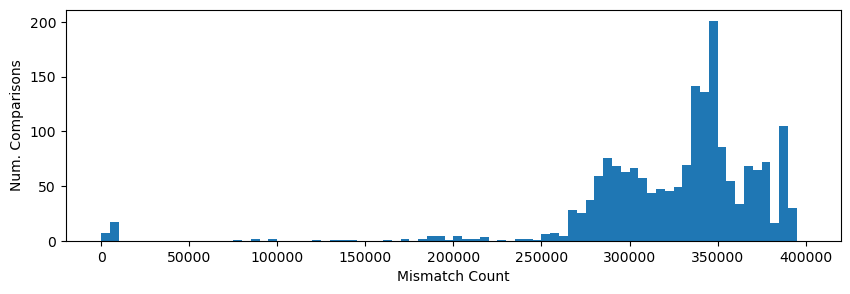

In [8]:
#plot mismatch count distributions
plt.figure(figsize=(10,3))
plt.hist(df['Mismatch Count'], bins=np.arange(0, df['Mismatch Count'].max()+1, 5000))
plt.ticklabel_format(style='plain')
plt.xlabel('Mismatch Count')
plt.ylabel('Num. Comparisons')
plt.show()

In [9]:
#strains pairs with fewer than 250 SNP differences
dups = df[df['Mismatch Count']< 250][['Query Sample', 'Genotyped Sample']]
dups

,Query Sample,Genotyped Sample
5,Tucson_4,Tucson_3
1224,730333_Guatelama,730332_Guatemala
1484,4545_Venezuela,4545-MICE_Venezuela
1593,4542_Venezuela,4545-MICE_Venezuela
1594,4542_Venezuela,4545_Venezuela
1708,3796_Venezuela,34698_Venezuela
1756,3490_Mexico,Tucson_24


In [10]:
dup_strains = dups['Query Sample'].tolist() + dups['Genotyped Sample'].tolist()

with open('duplicate_samples.txt', 'w') as f:
    f.write("\n".join(dup_strains))

In [11]:
#get avg. read depth for each duplicated sample

!vcftools --gzvcf {vcf} --keep duplicate_samples.txt --depth --out duplicate_samples


VCFtools - 0.1.17
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /Users/clairedubin/cocci/strain_sequencing/CpSilv_core_mapped/other_pops/all_strains_merged_all_valid_sites.renamed.vcf.gz
	--keep duplicate_samples.txt
	--depth
	--out duplicate_samples

Using zlib version: 1.2.11
Keeping individuals in 'keep' list
After filtering, kept 11 out of 61 Individuals
Outputting Mean Depth by Individual
After filtering, kept 27931432 out of a possible 27931432 Sites
Run Time = 201.00 seconds


In [12]:
dup_sample_depth = pd.read_csv('duplicate_samples.idepth', sep='\t').set_index('INDV')['MEAN_DEPTH'].to_dict()
dup_sample_depth

{'Tucson_3': 170.741,
 'Tucson_4': 73.5349,
 'Tucson_24': 112.65,
 '730332_Guatemala': 27.8499,
 '730333_Guatelama': 24.7623,
 '4545-MICE_Venezuela': 170.981,
 '4545_Venezuela': 47.384,
 '34698_Venezuela': 18.3499,
 '4542_Venezuela': 36.9776,
 '3796_Venezuela': 61.351,
 '3490_Mexico': 140.583}

In [13]:
def sample_with_lower_depth(s1, s2):
    d = {key: dup_sample_depth[key] for key in [s1, s2]} 
    return min(d, key=d.get)

dups['lower_depth_sample_to_drop'] = dups.apply(lambda x: sample_with_lower_depth(x['Query Sample'], x['Genotyped Sample']), axis=1)

In [14]:
dups

,Query Sample,Genotyped Sample,lower_depth_sample_to_drop
5,Tucson_4,Tucson_3,Tucson_4
1224,730333_Guatelama,730332_Guatemala,730333_Guatelama
1484,4545_Venezuela,4545-MICE_Venezuela,4545_Venezuela
1593,4542_Venezuela,4545-MICE_Venezuela,4542_Venezuela
1594,4542_Venezuela,4545_Venezuela,4542_Venezuela
1708,3796_Venezuela,34698_Venezuela,34698_Venezuela
1756,3490_Mexico,Tucson_24,Tucson_24


### Append dropped sample info to Table S1 from Teixeira et al 2019

https://pubmed.ncbi.nlm.nih.gov/31772050/

In [131]:
df = pd.read_csv('Teixeira_2019_TableS1_strain_info.csv', skiprows=1, dtype=str)
df = df[df['Species'] == 'Coccidioides posadasii'][df.columns[:5]]
df['Publication'] = df['Publication'].str.replace('current publication', 'Teixeira et al. 2019, mBio')

In [132]:
#append country names to strains from Teixeira et al
df.loc[df['Publication']=='Teixeira et al. 2019, mBio', 'Isolate ID'] = df['Isolate ID'].astype(str) + '_' + df['Country of isolation'].astype(str)

In [133]:
#drop lower depth samples and add note to samples kept

notes = {
    'Tucson_3': 'highly similar to Tucson_4 (Tucson_4 dropped)',
    '730332_Guatemala': 'highly similar to 730333_Guatemala (730333_Guatemala dropped)',
    '4545-MICE_Venezuela': 'highly similar to 4545_Venezuela and 4542 (4545_Venezuela and 4542_Venezuela dropped)',
    '3796_Venezuela': 'highly similar to 34698_Venezuela (34698_Venezuela dropped)',
    '3490_Mexico': 'highly similar to Tucson_24 (Tucson_24 dropped)',
}

df = df[~df['Isolate ID'].isin(dups['lower_depth_sample_to_drop'])]
df['Notes'] = df['Isolate ID'].map(notes)

df.head()

,SRA accesion number,Isolate ID,Species,Country of isolation,Publication,Notes
1,SRR6830881,4545-MICE_Venezuela,Coccidioides posadasii,Venezuela,"Teixeira et al. 2019, mBio",highly similar to 4545_Venezuela and 4542 (454...
4,SRR6830886,3796_Venezuela,Coccidioides posadasii,Venezuela,"Teixeira et al. 2019, mBio",highly similar to 34698_Venezuela (34698_Venez...
5,SRR6830885,2566_Venezuela,Coccidioides posadasii,Venezuela,"Teixeira et al. 2019, mBio",NaN
6,SRR6830888,JTORRES_Venezuela,Coccidioides posadasii,Venezuela,"Teixeira et al. 2019, mBio",NaN
7,SRR6830887,3490_Mexico,Coccidioides posadasii,Mexico,"Teixeira et al. 2019, mBio",highly similar to Tucson_24 (Tucson_24 dropped)


### Add population info

Tree from Teixeira et al 2022, table S1: https://academic.oup.com/g3journal/advance-article/doi/10.1093/g3journal/jkac031/6523976#supplementary-data

Labeled newick tree from Marcus Teixera via email in March 2022.

Strains GT 162 USA (from Texas) and Colorado Springs 1 (Colorado) do not have clear population assignments.

In [134]:
tree = dendropy.Tree.get(
        path='Teixeira_2022_FigS3_Cposadasii_tree.tree',
        schema='newick',
        rooting='force-unrooted')
print('number of samples in tree: {}'.format(len(tree)))

number of samples in tree: 63


In [135]:
#drop highly similar strains as above
tree_to_drop = [i.replace('_', ' ') for i in dups['lower_depth_sample_to_drop'].tolist()]
tree.prune_taxa_with_labels(tree_to_drop)

print('number of samples in tree: {}'.format(len(tree)))

number of samples in tree: 57


In [136]:
tree.as_string(schema='newick')

"[&U] (Reference:1.13653e-05,(((((((B0858_Guatemala:0.0035084064,B1249_Guatemala:0.0046641372)'78.9/93':0.0018642966,730332_Guatelama:0.0035711033999999997)'100/100':0.0112179236,(((3796_Venezuela:0.0002856372,'4545-MICE Venezuela':0.00026392259999999997)'100/100':4.17847e-05,2566_Venezuela:0.0003304389)'88.6/95':1.3797e-06,JTORRES_Venezuela:0.0003870392)'100/100':0.0159101942)'100/100':0.0045949314,(GT120_USA:0.017899466,3490_Mexico:0.0189690493)'40.7/33':0.0021749748)'100/100':0.0033926709,Sonora_2:0.0195682205)'100/57':0.0014981872,((B10813_Texas:0.0154888617,Michoacan_1:0.017086196)'100/100':0.00259203,((((((B5773_Brazil:0.0031743431,Sonora_1:0.0092022538)'20.3/50':0.001354544,Coahuila_2:0.0097125975)'100/100':0.001511764,GT002_Texas:0.0103928572)'100/90':0.001296572,(730334_Guatemala:0.0086058072,(San_Antonio_1:0.0088882206,Nuevo_Leon_2:0.009202438)'100/100':0.0037016786)'100/97':0.0016119465)'100/97':0.0022186995,Nuevo_Leon_1:0.0123612932)'100/96':0.0026293136,GT017_Paraguay:0.01

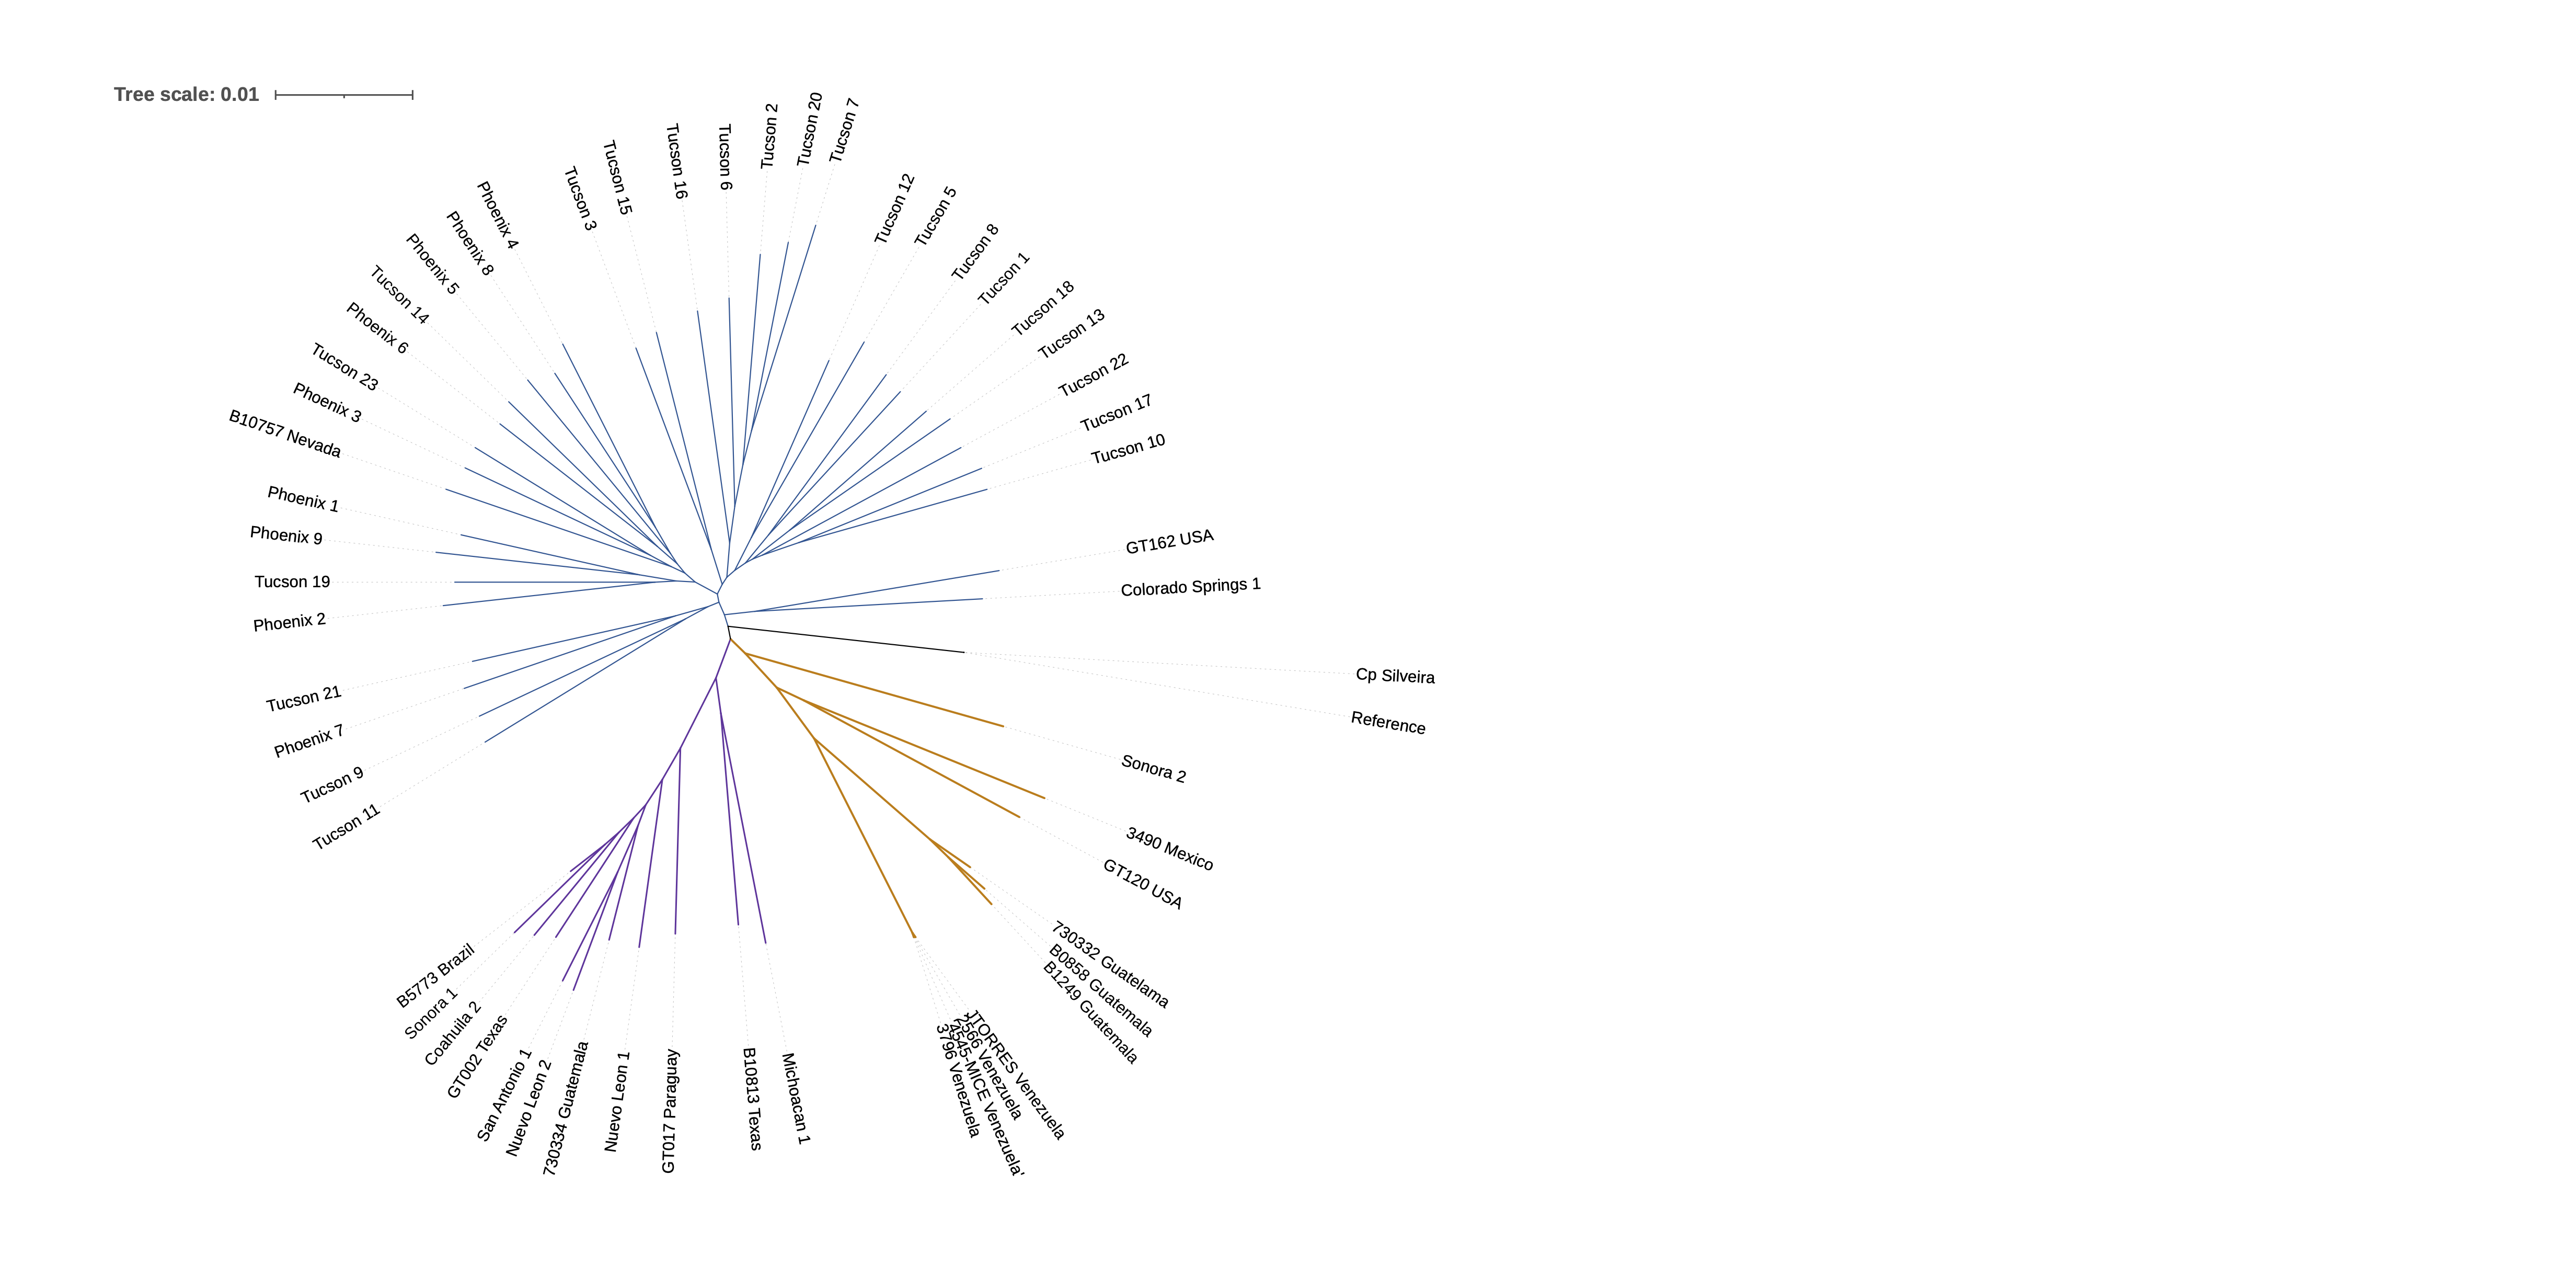

In [137]:
##tree visualized with ITOL

Image(filename='Teixeira_2022_FigS3_Cposadasii_tree.png')


In [138]:
#assign populations as in tree
#blue = AZ, purple = TX/MX/SA, yellow = CB

AZ_strains = """Tucson 11
Tucson 9
Phoenix 7
Tucson 21
Phoenix 2
Tucson 19
Phoenix 9
Phoenix 1
B10757 Nevada
Phoenix 3
Tucson 23
Phoenix 6
Tucson 14
Phoenix 5
Phoenix 8
Phoenix 4
Tucson 3
Tucson 15
Tucson 16
Tucson 6
Tucson 2
Tucson 20
Tucson 7
Tucson 12
Tucson 5
Tucson 8
Tucson 1
Tucson 18
Tucson 13
Tucson 22
Tucson 17
Tucson 10
GT162 USA
Colorado Springs 1""".replace(' ', '_').split('\n')

TXMXSA_strains = """Michoacan 1
B10813 Texas
GT017 Paraguay
Nuevo Leon 1
730334 Guatemala
Nuevo Leon 2
San Antonio 1
GT002 Texas
Coahuila 2
Sonora 1
B5773 Brazil""".replace(' ', '_').split('\n')

CB_strains = """Sonora 2
3490 Mexico
GT120 USA
730332 Guatemala
B0858 Guatemala
B1249 Guatemala
JTORRES Venezuela
2566 Venezuela
4545-MICE Venezuela
3796 Venezuela""".replace(' ', '_').split('\n')

In [139]:
len(AZ_strains), len(TXMXSA_strains), len(CB_strains)

(34, 11, 10)

In [140]:
pop_dict = {}

for strain in AZ_strains:
    pop_dict[strain] = 'AZ'
    
for strain in TXMXSA_strains:
    pop_dict[strain]='TXMXSA'
    
for strain in CB_strains:
    pop_dict[strain]='CB'

In [141]:
pop_df = pd.DataFrame.from_dict(pop_dict, orient='index', )
pop_df.columns = ['Population']

df = df.merge(pop_df, left_on='Isolate ID', right_index=True)

In [142]:
df.head()

,SRA accesion number,Isolate ID,Species,Country of isolation,Publication,Notes,Population
1,SRR6830881,4545-MICE_Venezuela,Coccidioides posadasii,Venezuela,"Teixeira et al. 2019, mBio",highly similar to 4545_Venezuela and 4542 (454...,CB
4,SRR6830886,3796_Venezuela,Coccidioides posadasii,Venezuela,"Teixeira et al. 2019, mBio",highly similar to 34698_Venezuela (34698_Venez...,CB
5,SRR6830885,2566_Venezuela,Coccidioides posadasii,Venezuela,"Teixeira et al. 2019, mBio",NaN,CB
6,SRR6830888,JTORRES_Venezuela,Coccidioides posadasii,Venezuela,"Teixeira et al. 2019, mBio",NaN,CB
7,SRR6830887,3490_Mexico,Coccidioides posadasii,Mexico,"Teixeira et al. 2019, mBio",highly similar to Tucson_24 (Tucson_24 dropped),CB


### Add admixture info

I'm considering a strain admixed if its maximum population assignment value is less than 99%

In [143]:
admix = pd.read_csv('Teixeira_2022_FigS3_admixture.csv')
admix['max_pop'] = admix[['P1', 'P2', 'P3']].max(axis=1)

strain_name_conversion = pd.read_csv('strain_name_conversion.txt',header=None)
strain_name_conversion.columns = ['Ind', 'strain']

admix = admix.merge(strain_name_conversion, on='Ind')[['strain','P1', 'P2', 'P3', 'max_pop']]

In [144]:
admix.sort_values('max_pop')

,strain,P1,P2,P3,max_pop
0,B0858_Guatemala,0.000001,0.491778,0.508221,0.508221
3,B1249_Guatemala,0.000001,0.482385,0.517614,0.517614
10,730333_Guatemala,0.000001,0.473972,0.526027,0.526027
9,730332_Guatemala,0.000001,0.473933,0.526066,0.526066
39,Tucson_24,0.000001,0.445772,0.554227,0.554227
...,...,...,...,...,...
34,Tucson_23,0.000001,0.999999,0.000001,0.999999
37,Sonora_1,0.999999,0.000001,0.000001,0.999999
5,34698_Venezuela,0.000001,0.000001,0.999999,0.999999
24,Tucson_13,0.000001,0.999999,0.000001,0.999999


In [145]:
admix[admix['max_pop'] >= .99].shape

(46, 5)

In [146]:
admixed_strains = admix[admix['max_pop'] <= .99]['strain'].tolist()

In [147]:
df['Admixed'] = df['Isolate ID'].isin(admixed_strains)

In [148]:
print('# AZ strains w/o admixture: {}'.format(df[(df['Population']=='AZ') & ~(df['Admixed'])].shape[0]))
print('# TXMXSA strains w/o admixture: {}'.format(df[(df['Population']=='TXMXSA') & ~(df['Admixed'])].shape[0]))
print('# CB strains w/o admixture: {}'.format(df[(df['Population']=='CB') & ~(df['Admixed'])].shape[0]))

# AZ strains w/o admixture: 29
# TXMXSA strains w/o admixture: 8
# CB strains w/o admixture: 4


### Export sample info and population assignments

In [150]:
df = df[['Isolate ID','SRA accesion number','Publication','Population','Admixed','Country of isolation','Notes',]]

In [151]:
df.to_csv('isolate_and_population_info.csv', index=None)

In [155]:
for strain in admixed_strains:
    if strain in pop_dict:
        del pop_dict[strain]

In [156]:
with open('pop_dict.json', 'w') as f:
    json.dump(pop_dict, f)

In [154]:
pop_dict

{'Tucson_9': 'AZ',
 'Phoenix_7': 'AZ',
 'Tucson_21': 'AZ',
 'Phoenix_2': 'AZ',
 'Tucson_19': 'AZ',
 'Phoenix_9': 'AZ',
 'Phoenix_1': 'AZ',
 'B10757_Nevada': 'AZ',
 'Phoenix_3': 'AZ',
 'Tucson_23': 'AZ',
 'Phoenix_6': 'AZ',
 'Tucson_14': 'AZ',
 'Phoenix_5': 'AZ',
 'Phoenix_8': 'AZ',
 'Phoenix_4': 'AZ',
 'Tucson_3': 'AZ',
 'Tucson_15': 'AZ',
 'Tucson_6': 'AZ',
 'Tucson_12': 'AZ',
 'Tucson_5': 'AZ',
 'Tucson_8': 'AZ',
 'Tucson_1': 'AZ',
 'Tucson_18': 'AZ',
 'Tucson_13': 'AZ',
 'Tucson_22': 'AZ',
 'Tucson_17': 'AZ',
 'Tucson_10': 'AZ',
 'GT162_USA': 'AZ',
 'Colorado_Springs_1': 'AZ',
 'Nuevo_Leon_1': 'TXMXSA',
 '730334_Guatemala': 'TXMXSA',
 'Nuevo_Leon_2': 'TXMXSA',
 'San_Antonio_1': 'TXMXSA',
 'GT002_Texas': 'TXMXSA',
 'Coahuila_2': 'TXMXSA',
 'Sonora_1': 'TXMXSA',
 'B5773_Brazil': 'TXMXSA',
 'JTORRES_Venezuela': 'CB',
 '2566_Venezuela': 'CB',
 '4545-MICE_Venezuela': 'CB',
 '3796_Venezuela': 'CB'}

In [88]:
pop_dict = json.load(open('pop_dict.json', 'r'))

s=''
for i in pop_dict:
    
    if pop_dict[i] == 'AZ':
        s += '"{}",'.format(i)
        
print(s)

"Tucson_9","Phoenix_7","Tucson_21","Phoenix_2","Tucson_19","Phoenix_9","Phoenix_1","B10757_Nevada","Phoenix_3","Tucson_23","Phoenix_6","Tucson_14","Phoenix_5","Phoenix_8","Phoenix_4","Tucson_3","Tucson_15","Tucson_6","Tucson_12","Tucson_5","Tucson_8","Tucson_1","Tucson_18","Tucson_13","Tucson_22","Tucson_17","Tucson_10","GT162_USA","Colorado_Springs_1",


In [89]:
pop_dict = json.load(open('pop_dict.json', 'r'))

s=''
for i in pop_dict:
    
    if pop_dict[i] == 'TXMXSA':
        s += '"{}",'.format(i)
        
print(s)

"Nuevo_Leon_1","730334_Guatemala","Nuevo_Leon_2","San_Antonio_1","GT002_Texas","Coahuila_2","Sonora_1","B5773_Brazil",


In [90]:
pop_dict = json.load(open('pop_dict.json', 'r'))

s=''
for i in pop_dict:
    
    if pop_dict[i] == 'CB':
        s += '"{}",'.format(i)
        
print(s)

"JTORRES_Venezuela","2566_Venezuela","4545-MICE_Venezuela","3796_Venezuela",
